In [1]:
import numpy as np
import commentjson
import matplotlib.pyplot as plt

with open('input.json') as f:
    data = commentjson.load(f)
arithmetics = ['sum','prod']

# todo lists
# correlation
# constraint on variable
# saving memory allocations

In [2]:
def get_intkey_dict(d):
    tmp = {}
    for key in d:
        ind_var = int(key)
        tmp[ind_var] = d[key]
    return tmp

class Simulator:
    # default constructor
    def __init__(self, data):
        np.random.seed(0)
        self.data_check(data)
        self.data = data
        self.sde = get_intkey_dict(self.data['sde']) # change string key to integer key        
        self.num_vars = data['num_vars']
        self.x0 = data['x0']
        self.num_steps = data["num_steps"]
        self.num_paths = data['num_paths']
        self.vars = np.zeros((data["num_steps"]+1, data["num_vars"], data["num_paths"]))
        for ind, x0 in enumerate(self.x0):
            self.vars[0, ind, :] = x0
        self.dW_indep = np.random.normal(0.0,1.0,(data["num_steps"]+1, data["num_B"], data["num_paths"])) # independent brownian motions
        self.normalize()
        if "corr" in data.keys():
            self.corr = np.matrix(data["corr"])
            self.L = np.linalg.cholesky(self.corr) # Cholesky decomposition for computing correlated Brownian motions
            self.dW = np.zeros((data["num_steps"]+1, data["num_B"], data["num_paths"]))
            for i in range(self.dW.shape[0]):
                self.dW[i] = np.matmul(self.L, self.dW_indep[i])
        else:
            self.dW = self.dW_indep
        self.maturity = data['maturity']
        self.dt = self.maturity / self.num_steps
        self.sqrt_dt = np.sqrt(self.dt)
        self.t_sim = np.linspace(0.0, self.maturity, self.num_steps+1)
        
    def data_check(self, data):
        if len(data["x0"]) != data["num_vars"]:
            print("Number of variables in initial value and definition are mismatching!")
            exit(-1)
            
    def normalize(self):
        shape = self.dW_indep.shape
        self.dW_indep = self.dW_indep.reshape(-1)
        self.dW_indep = (self.dW_indep - self.dW_indep.mean())/self.dW_indep.std()
        self.dW_indep = self.dW_indep.reshape(shape)
            
    def simulate(self):
        for step, t in enumerate(self.t_sim):
            if step == 0: continue
            prev_step = step-1
            self.vars[step] = self.vars[prev_step] # copy previous values
            for lhs_ind, item in self.sde.items():
                # compute drift
        #         res = compute(item['drift'], self.vars[prev_step], self.num_paths, log=True)
                res = compute(item['drift'], self.vars[prev_step,:,:], self.num_paths)
                self.vars[step,lhs_ind,:] += res*sim.dt
                # compute volatility
                for vol in item['vol']:
                    dW_ind, vol_term = vol
                    res = compute(vol_term, self.vars[prev_step,:,:], self.num_paths)
                    self.vars[step,lhs_ind,:] += res*self.sqrt_dt*self.dW[step,dW_ind,:]
            # Check constraints
            if "constraints" in self.data.keys():
#                 continue
                for key, item in self.data['constraints'].items():
                    if key == 'min':
                        self.vars[step,item[0],:] = np.maximum(item[1], self.vars[step,item[0],:]) # item[0]: variable's index. item[1]: value for constraint
                    elif key == 'max':
                        self.vars[step,item[0],:] = np.minimum(item[1], self.vars[step,item[0],:]) # item[0]: variable's index. item[1]: value for constraint

# someday, I am going to also add buffer for each level.
def compute(arr, prev_vars, num_paths, level=0, log=False):
    term_type = arr[0]
    result = np.zeros(num_paths)
    if type(term_type) != str:
        print("Object for the type of a term must be a string!")
    if term_type in arithmetics: # sum or prod
        if log: print("going to do ", term_type)
        if term_type == 'sum':
            for i in range(1, len(arr)):
                result += compute(arr[i], prev_vars, num_paths, level=level+1)            
        elif term_type == 'prod':
            result[:] = 1.0
            for i in range(1, len(arr)):
                result *= compute(arr[i], prev_vars, num_paths, level=level+1)
    else: # mathematical expressions
        if log: print("Mathematical expression is going to be computed")
        if term_type == 'const':
            if log: print("It is constant ", arr[1])
            result += arr[1]
        elif term_type == 'poly':
            coef = arr[1]; ind = arr[2]; power = arr[3]
            if log: print("It is polynomial ", coef, ind, power)
            result += coef * np.power(prev_vars[ind], power)
            
    return result

# Test Case

In [3]:
# Ordinary differential equation
json_string = """
{
    "num_vars": 1, # hehe
    "num_B": 1,
    "num_paths": 1,
    "num_steps": 500,
    "maturity": 10,
    "x0": [0.0],
    "sde":{
        "0":{
            "drift": ["sum", ["poly", -1.0, 0, 1], ["const", 1.0]], # drift term
            "vol": [[0, ["const",0]]] # one volatility term
        }
    }
}
"""
test_data = commentjson.loads(json_string)
sim = Simulator(test_data)
exact_sol = 1.0 + np.exp(-sim.t_sim)*(sim.x0[0]-1.0)
sim.simulate()

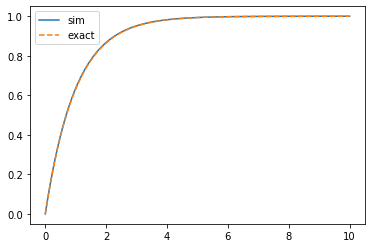

In [4]:
plt.plot(sim.t_sim, sim.vars[:,0,0], label='sim')
plt.plot(sim.t_sim, exact_sol, label='exact', linestyle='--')
plt.legend()

# Process with normal distribution

In [5]:
# Bachilier model (normal)
json_string = """
{
    "num_vars": 2, # hehe
    "num_B": 2,
    "num_paths": 10000,
    "num_steps": 100,
    "maturity": 1,
    "x0": [0.0, 0.0],
    "corr": [[1,0],[0,1]],
    "sde":{
        "0":{
            "drift": ["const", 5.0], # drift term
            "vol": [[0, ["const",2]]] # one volatility term
        },
        "1":{
            "drift": ["const", -2.0], # drift term
            "vol": [[1, ["const",0.5]]] # one volatility term
        }
    }
}
"""
test_data = commentjson.loads(json_string)
sim = Simulator(test_data)
sim.simulate()

5.0036692848055795
1.9924401785809016


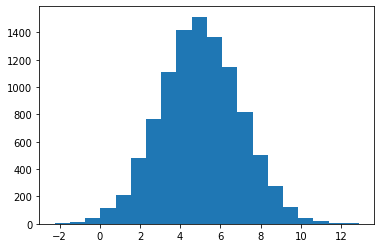

In [6]:
plt.hist(sim.vars[-1,0,:],bins=20)
print(sim.vars[-1,0,:].mean())
print(sim.vars[-1,0,:].std())

-2.000463910882772
0.4938606692551125


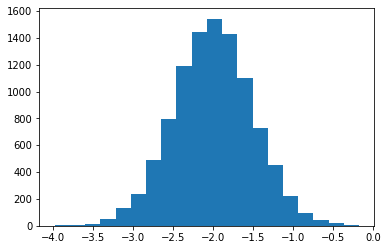

In [7]:
plt.hist(sim.vars[-1,1,:],bins=20)
print(sim.vars[-1,1,:].mean())
print(sim.vars[-1,1,:].std())

In [8]:
np.max(np.abs(sim.dW - sim.dW_indep))

0.0

# CIR Process 

In [9]:
# CIR model (normal)
json_string = """
{
    "num_vars": 2, # hehe
    "num_B": 2,
    "num_paths": 5000,
    "num_steps": 1000,
    "maturity": 1,
    "x0": [0.0, 0.04],
    "corr": [[1,-0.6],[-0.6,1]],
    "constraints":{
        "min": [1, 0.0] # 1st var's min value should be 0.0
    },
    "sde":{
        "0":{
            "drift": ["poly", -0.5, 1, 1], # drift term
            "vol": [[0, ["poly",1.0,1,0.5]]] # one volatility term
        },
        "1":{
            "drift": ["sum", ["const", 0.015], ["poly",-0.3,1,1]], # drift term
            "vol": [[1, ["poly",0.5,1,0.5]]] # one volatility term
        }
    }
}
"""
test_data = commentjson.loads(json_string)
sim = Simulator(test_data)
sim.simulate()

In [10]:
print(sim.vars[-1,0,:].mean())
print(sim.vars[-1,0,:].std())
print(sim.vars[-1,1,:].mean())
print(sim.vars[-1,1,:].std())

-0.020666340113933427
0.2202103764454752
0.04585056666092981
0.08973778450602793
